In [16]:
import torch
import torch.nn as nn
import gpytorch
from matplotlib import pyplot as plt


In [17]:
class DeepFeatureExtractor(nn.Module):  # Defining deep kernel network
    def __init__(self):
        super(DeepFeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # 2D feature output for GP kernel

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Feature space transformation

In [18]:
import torch
import gpytorch
from matplotlib import pyplot as plt

In [19]:
class DKLGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(DKLGPModel, self).__init__(train_x, train_y, likelihood)
        self.feature_extractor = DeepFeatureExtractor()
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        projected_x = self.feature_extractor(x)  # Transform input
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [20]:
# Training data
train_x = torch.linspace(-4, 4, 100).reshape(-1, 1)
train_y = torch.sin(train_x) + torch.randn_like(train_x) * 0.1


In [21]:
# Initialize model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = DKLGPModel(train_x, train_y.squeeze(), likelihood)

In [22]:
# Training mode
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [23]:
# Optimizer and marginal log likelihood
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [24]:
# Training loop
for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y.squeeze())
    loss.backward()
    optimizer.step()

    if i % 20 == 0:
        print(f'Iter {i+1}/100 - Loss: {loss.item():.3f}')

Iter 1/100 - Loss: 1.099
Iter 21/100 - Loss: 0.781
Iter 41/100 - Loss: 0.703
Iter 61/100 - Loss: 0.626
Iter 81/100 - Loss: 0.545


In [25]:
# Evaluation mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [26]:
# Test data
test_x = torch.linspace(-4, 4, 100).reshape(-1, 1)

In [27]:
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = model(test_x)
    mean = pred.mean
    lower, upper = pred.confidence_region()

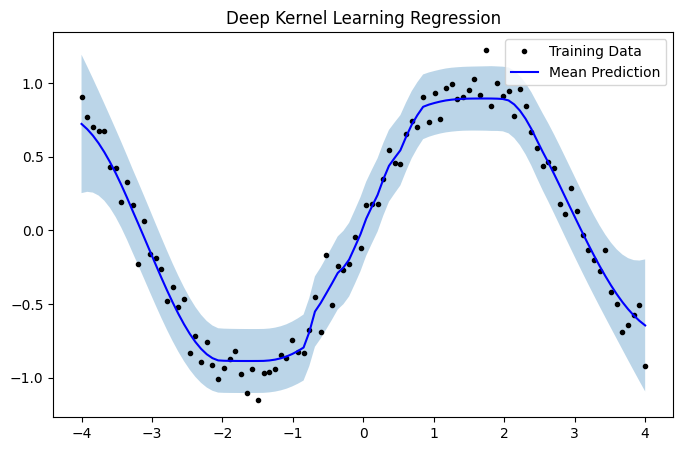

In [28]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(train_x.numpy(), train_y.numpy(), "k.", label="Training Data")
plt.plot(test_x.numpy(), mean.numpy(), 'b', label="Mean Prediction")
plt.fill_between(test_x.numpy().flatten(), lower.numpy(), upper.numpy(), alpha=0.3)
plt.legend()
plt.title("Deep Kernel Learning Regression")
plt.show()